In [1]:
SAVEFIG = False
# Setting this to True will alter the matplotlib settings to save the figures in a format used in our paper

In [2]:
###########
# Imports #
###########

import os
import pickle
import numpy as np
from matplotlib import pyplot as plt

from explainer import Explanation

###########
# Figures #
###########

if not SAVEFIG:
    plt.rcParams.update({'figure.figsize': (15/2.54, 9/2.54)})
else:
    plt.rcParams.update({'figure.figsize': (15/2.54, 9/2.54/1.4), 'font.size': 13})

exp = pickle.load(open('explanations/norway_car_12.explanation.pckl', 'rb'))
f_weights = {feature: list() for feature in exp.base_features}

savedir = './figures/'

#######
# QoE #
#######

M_IN_K = 1000.0
REBUF_PENALTY = 4.3
SMOOTH_PENALTY = 1
BITRATES = [300,750,1200,1850,2850,4300]

HEADER_FILE = 'headers.csv'

def compute_qoe(trace_file):
    data = np.loadtxt(open(trace_file, 'r'), delimiter = ',')
    headers = np.array(open(HEADER_FILE, 'r').readline().strip().split(','))
    
    return data[:, np.where(headers == 'reward')[0][0]]

def simulate(qualities, points): # -> to same metric as Pensieve
    BUFFER = 20000
    CONST = 1 / 1000
    
    def bounds(r, s):
        return r[(r < s).argmin()-1], r[(r < s).argmin()]
    
    def period(r1, r2, s):
        assert r1 < s < r2
        return BUFFER * (1 / (s - r1) + 1 / (r2 - s))
    
    def reward(r, s):
        assert min(r) <= s <= max(r)
        if s in r:
            # return CONST * s
            return 0
        else:
            r1, r2 = bounds(r, s)
            t = period(r1, r2, s)
            # return CONST * (s - 2 / t * (r2 - r1))
            return CONST * (- 2 / t * (r2 - r1))
        
    qualities = np.array(sorted(qualities))
    
    return [reward(qualities, s) for s in points]

# Output section

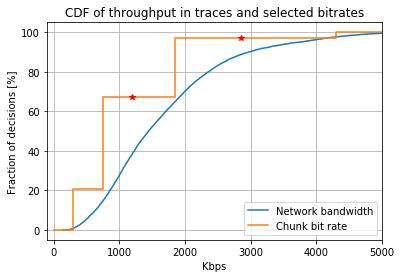

In [3]:
speeds = list()
for trace in os.listdir('net_traces/traces/'):
    lines = open('net_traces/traces/' + trace).readlines()
    speeds.extend([1000 * float(b) for _, b in [line.strip().split() for line in lines]])
    
h, edges = np.histogram(speeds, density=True, bins=len(speeds))
h = np.append([0], np.cumsum(h)/np.cumsum(h).max())
plt.step(edges, 100 * h, label = 'Network bandwidth')

##########

global_probabilities = np.zeros((6,))

for f in ('explanations/' + f for f in os.listdir('explanations/') if f.startswith('norway')):
    exp = pickle.load(open(f, 'rb'))
    for p in exp._class_probs:
        global_probabilities += p
        
global_probabilities /= sum(global_probabilities)

cdf = np.cumsum(global_probabilities)

plt.step([0, 300, 750, 1200, 1850, 2850, 4300, 5000], 100 * np.hstack([[0], cdf, [1]]), where = 'post', label = 'Chunk bit rate')
    
##########

plt.xlabel('Kbps')
plt.xlim(-100, 5000)
plt.ylabel('Fraction of decisions [%]')
plt.plot(1200, 100 * cdf[2], 'r*')
plt.plot(2850, 100 * cdf[4], 'r*')
if not SAVEFIG: plt.title('CDF of throughput in traces and selected bitrates')
plt.legend()
plt.grid()

if SAVEFIG: plt.savefig(savedir + 'output_speed_cdf.pdf', transparent=True, bbox_inches="tight")

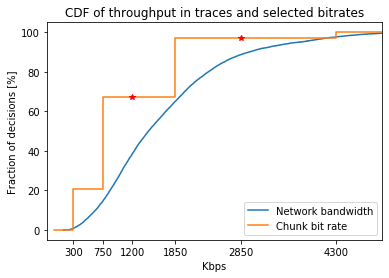

In [4]:
speeds = list()
for trace in os.listdir('net_traces/traces/'):
    lines = open('net_traces/traces/' + trace).readlines()
    speeds.extend([1000 * float(b) for _, b in [line.strip().split() for line in lines]])
    
h, edges = np.histogram(speeds, density=True, bins=len(speeds))
h = np.append([0], np.cumsum(h)/np.cumsum(h).max())
plt.step(edges, 100 * h, label = 'Network bandwidth')

##########

global_probabilities = np.zeros((6,))

for f in ('explanations/' + f for f in os.listdir('explanations/') if f.startswith('norway')):
    exp = pickle.load(open(f, 'rb'))
    for p in exp._class_probs:
        global_probabilities += p
        
global_probabilities /= sum(global_probabilities)

cdf = np.cumsum(global_probabilities)

plt.step([0, 300, 750, 1200, 1850, 2850, 4300, 5000], 100 * np.hstack([[0], cdf, [1]]), where = 'post', label = 'Chunk bit rate')
    
##########

plt.xlabel('Kbps')
plt.xlim(-100, 5000)
plt.xticks([300, 750, 1200, 1850, 2850, 4300])
plt.ylabel('Fraction of decisions [%]')
plt.plot(1200, 100 * cdf[2], 'r*')
plt.plot(2850, 100 * cdf[4], 'r*')
if not SAVEFIG: plt.title('CDF of throughput in traces and selected bitrates')
plt.legend(loc='lower right')

if SAVEFIG: plt.savefig(savedir + 'output_speed_cdf_pp.pdf', transparent=True, bbox_inches="tight")

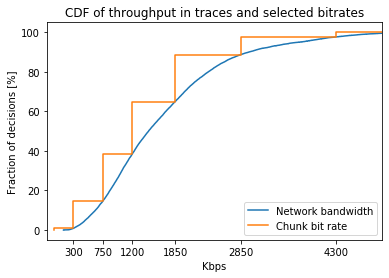

In [5]:
speeds = list()
for trace in os.listdir('net_traces/traces/'):
    lines = open('net_traces/traces/' + trace).readlines()
    speeds.extend([1000 * float(b) for _, b in [line.strip().split() for line in lines]])
    
h, edges = np.histogram(speeds, density=True, bins=len(speeds))
h = np.append([0], np.cumsum(h)/np.cumsum(h).max())
plt.step(edges, 100 * h, label = 'Network bandwidth')

##########

x = [300, 750, 1200, 1850, 2850, 4300]
indices = edges.searchsorted(x)
y = h[indices]

plt.step(np.hstack([[0], x, [5000]]), 100 * np.hstack([[0], y, [1]]), where = 'pre', label = 'Chunk bit rate')
    
##########

plt.xlabel('Kbps')
plt.xlim(-100, 5000)
plt.xticks(x)
plt.ylabel('Fraction of decisions [%]')
if not SAVEFIG: plt.title('Expected CDF of throughput in traces and selected bitrates')
plt.legend(loc='lower right')

if SAVEFIG: plt.savefig(savedir + 'output_speed_cdf_pp_expected.pdf', transparent=True, bbox_inches="tight")

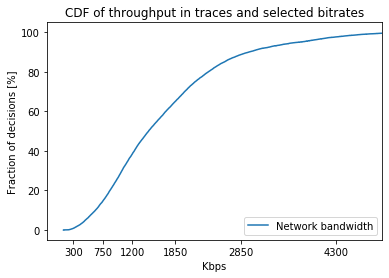

In [6]:
speeds = list()
for trace in os.listdir('net_traces/traces/'):
    lines = open('net_traces/traces/' + trace).readlines()
    speeds.extend([1000 * float(b) for _, b in [line.strip().split() for line in lines]])
    
h, edges = np.histogram(speeds, density=True, bins=len(speeds))
h = np.append([0], np.cumsum(h)/np.cumsum(h).max())
plt.step(edges, 100 * h, label = 'Network bandwidth')

##########
    
##########

plt.xlabel('Kbps')
plt.xlim(-100, 5000)
plt.xticks(x)
plt.ylabel('Fraction of decisions [%]')
if not SAVEFIG: plt.title('CDF of throughput in traces')
plt.legend(loc='lower right')

if SAVEFIG: plt.savefig(savedir + 'output_speed_cdf_pp_netonly.pdf', transparent=True, bbox_inches="tight")

[2.05216636e-01 4.66502252e-01 2.22021159e-03 2.97654124e-01
 3.06925202e-04 2.80998518e-02]


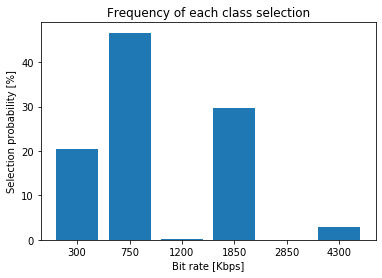

In [7]:
plt.bar(list(map(str, [300, 750, 1200, 1850, 2850, 4300])), 100 * global_probabilities)
plt.xlabel('Bit rate [Kbps]')
plt.ylabel('Selection probability [%]')
if not SAVEFIG: plt.title('Frequency of each class selection')


if SAVEFIG: plt.savefig(savedir + 'output_decision_bars.pdf', transparent=True, bbox_inches="tight")
print(global_probabilities)

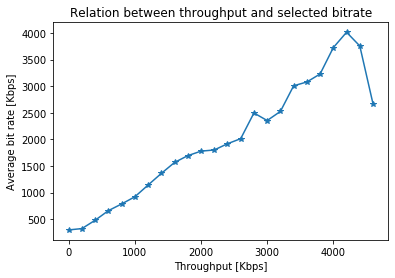

In [8]:
def all_pairs():
    headers = np.array(open('headers.csv', 'r').readline().strip().split(','))
    bitrates = [300, 750, 1200, 1850, 2850, 4300]
    
    for trace in os.listdir('exec_traces/normal_agent/'):
        data = np.loadtxt(open('exec_traces/normal_agent/' + trace, 'r'), delimiter = ',')
        
        actions = data[:, np.where(headers == 'action')[0][0]]
        speeds = data[:, np.where(headers == 'throughput_7')[0][0]]
        
        for a, s in zip(actions, speeds):
            yield bitrates[int(a)], 8000 * s

STEP = 200
speeds = list(range(0, 4800, STEP))
bins = [list() for _ in speeds]

for br, sp in all_pairs():
    bins[int(sp / STEP)].append(br)
    
#print(list(len(bin_) for bin_ in bins))
    
bitrates = np.array([np.mean(bin_) for bin_ in bins])
std_br = np.array([np.std(bin_) for bin_ in bins])

plt.plot(speeds, bitrates, '*-')
plt.plot(speeds, bitrates-std_br, '--', color='tab:gray', linewidth=0.6)
plt.plot(speeds, bitrates+std_br, '--', color='tab:gray', linewidth=0.6)
plt.xlabel('Throughput [Kbps]')
plt.ylabel('Average bit rate [Kbps]')
plt.grid()
if not SAVEFIG: plt.title('Relation between throughput and selected bitrate')


if SAVEFIG: plt.savefig(savedir + 'output_speed_bitrate.pdf', transparent=True, bbox_inches="tight")

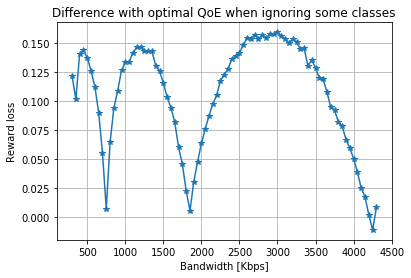

In [9]:
pensieve_qoe = list()
for br in range(300, 4301, 50):
    pensieve_qoe.append(np.mean(compute_qoe(f'exec_traces/normal_agent_constant_throughput/constant_{br}_kbps.csv')) - br / 1000)
plt.plot(range(300, 4301, 50), -np.array(pensieve_qoe), '-*', label = 'Pensieve reward')


#plt.plot(range(300, 4301, 50), -np.array(simulate([300, 750, 1200, 1850, 2850, 4300], range(300, 4301, 50))), label='20 Mb buffer, all bit rates')
#plt.plot(range(300, 4301, 50), -np.array(simulate([300, 750, 1850, 4300], range(300, 4301, 50))), label='20Mb buffer, ifour bit rates')
    
    
plt.xlabel('Bandwidth [Kbps]')
plt.ylabel('Reward loss')
#plt.ylim(0, .2)
plt.grid()
if not SAVEFIG: plt.title('Difference with optimal QoE when ignoring some classes')
#plt.legend()


if SAVEFIG: plt.savefig(savedir + 'output_qoe_loss.pdf', transparent=True, bbox_inches="tight")

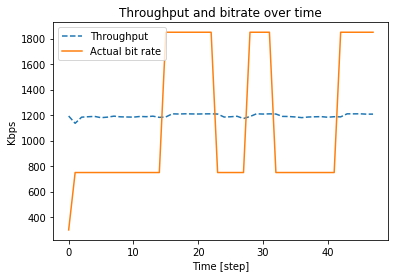

In [10]:
exp = pickle.load(open('explanations/constant_1200_kbps.explanation.pckl', 'rb'))

# Plot the network speed and expected bitrate over time
time = list(range(exp.length))
values = exp.values_over_time('throughput_7') * 8000
plt.plot(time, values, '--', label = 'Throughput')

#expected = np.zeros(exp.length)
#for class_, probs in zip(exp.classes, exp.probs_over_time()):
#    expected += int(class_.strip('kbps')) * probs
#plt.plot(time, expected, label = 'Expected bitrate')

classes = exp._data['classes']
bitrate = [[300, 750, 1200, 1850, 2850, 4300][int(cl)] for cl in classes]
plt.plot(time, bitrate, label = 'Actual bit rate')

if not SAVEFIG: plt.title('Throughput and bitrate over time')
plt.legend(loc='upper left')
plt.xlabel('Time [step]')
plt.ylabel('Kbps')

if SAVEFIG: plt.savefig(savedir + 'output_constant_trace.pdf', transparent=True, bbox_inches="tight")

0.0 0.4900197982788086
0.020393192488262123 0.5648407148363445
0.043133802816900144 0.6396616313938803
0.06352699530516222 0.7144825479514162
0.09565727699530228 0.7893034645089521
0.13864436619718265 0.864124381066488
0.21126760563380229 0.9389452976240238


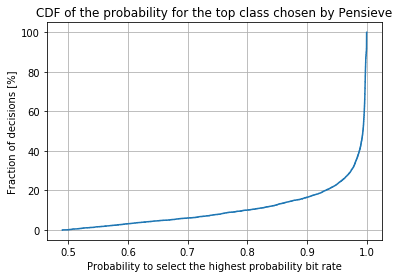

In [11]:
values = list()

for f in ('explanations/' + f for f in os.listdir('explanations/') if f.startswith('norway')):
    exp = pickle.load(open(f, 'rb'))
    probs = exp._class_probs # Get selected classes
    
    for prob in probs:
        values.append(prob.max())
            

h, edges = np.histogram(values, density=True, bins=len(values))
h = np.append([0], np.cumsum(h)/np.cumsum(h).max())
plt.step(edges, 100 * h)
#h, edges = np.histogram(values, density=True, bins = len(values))
#plt.plot(edges[1:], h)

for a, b in zip(h[::1000].tolist(), edges[::1000].tolist()):
    print(a,b)

if not SAVEFIG: plt.title('CDF of the probability for the top class chosen by Pensieve')
plt.xlabel('Probability to select the highest probability bit rate')
plt.ylabel('Fraction of decisions [%]')
plt.grid()

if SAVEFIG: plt.savefig(savedir + 'output_confidence.pdf', transparent=True, bbox_inches="tight")

# Input section

In [12]:
weights = {k: 0 for k in exp.base_features}

for f in ('explanations/' + f for f in os.listdir('explanations/') if f.startswith('norway')):
    exp = pickle.load(open(f, 'rb'))
    for k in exp.base_features:
        weights[k] += sum(exp.weights_over_time(k)) / len(exp.weights_over_time(k))
    
global_weights = sorted(weights.keys(), key = weights.__getitem__, reverse = True)
total_weight = sum(weights.values())
for f in global_weights:
    print(f'{f.ljust(max((len(f) for f in weights.keys())))} (overall weight: {round(weights[f], 2)} => {round(weights[f] / total_weight, 3)})')

last_quality_7     (overall weight: 53.51 => 0.377)
buffer_7           (overall weight: 26.07 => 0.184)
throughput_7       (overall weight: 21.86 => 0.154)
throughput_6       (overall weight: 4.0 => 0.028)
latency_6          (overall weight: 2.61 => 0.018)
latency_7          (overall weight: 2.58 => 0.018)
throughput_0       (overall weight: 2.37 => 0.017)
latency_0          (overall weight: 1.98 => 0.014)
throughput_5       (overall weight: 1.87 => 0.013)
latency_5          (overall weight: 1.87 => 0.013)
latency_4          (overall weight: 1.86 => 0.013)
throughput_3       (overall weight: 1.77 => 0.012)
latency_3          (overall weight: 1.65 => 0.012)
throughput_2       (overall weight: 1.64 => 0.012)
latency_2          (overall weight: 1.61 => 0.011)
latency_1          (overall weight: 1.58 => 0.011)
throughput_1       (overall weight: 1.51 => 0.011)
next_size_5        (overall weight: 1.47 => 0.01)
next_size_4        (overall weight: 1.46 => 0.01)
next_size_3        (overall wei

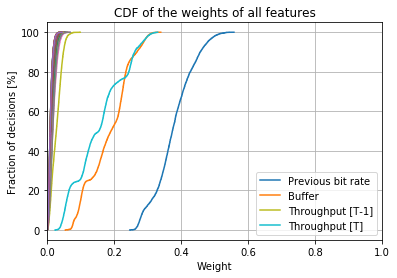

In [13]:
f_weights = {feature: list() for feature in exp.base_features}

for f in ('explanations/' + f for f in os.listdir('explanations/') if f.startswith('norway')):
    exp = pickle.load(open(f, 'rb'))
    for k in exp.base_features:
        f_weights[k] += exp.weights_over_time(k).tolist()
        
replace_str = {'last_quality_7': 'Previous bit rate',
               'buffer_7': 'Buffer',
               'throughput_6': 'Throughput [T-1]',
               'throughput_7': 'Throughput [T]',
              }

for k in f_weights:
    h, edges = np.histogram(f_weights[k], density=True, bins=len(f_weights[k]))
    h = np.append([0], np.cumsum(h)/np.cumsum(h).max())
    #plt.step(edges, 100 * h, label = replace_str[k] k if max(f_weights[k]) > 0.08 else None)
    plt.step(edges, 100 * h, label = replace_str[k] if k in replace_str else None)

if not SAVEFIG: plt.title(f'CDF of the weights of all features')
plt.xlabel('Weight')
plt.ylabel('Fraction of decisions [%]')
plt.xlim((0,1))
plt.legend(loc='lower right')
plt.grid()
    
if SAVEFIG: plt.savefig(savedir + 'input_weight_cdf.pdf', transparent=True, bbox_inches="tight")

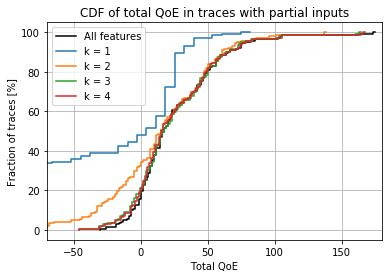

In [14]:
qoes = list()
avg_qoes = dict()

for trace in os.listdir('exec_traces/normal_agent/'):
    qoes.append(sum(compute_qoe('exec_traces/normal_agent/' + trace)))
    
h, edges = np.histogram(qoes, density=True, bins=len(qoes))
h = np.append([0], np.cumsum(h)/np.cumsum(h).max())
plt.step(edges, 100 * h, 'k', label = 'All features')
avg_qoes[25] = round(np.mean(qoes), 1), round(np.std(qoes), 1)


#top_features = ['previous quality', 'buffer', 'throuthput [T]', 'throughput [T-1]', 'download time [T-1]', 'download time [T]', 'more...']
top_features = ['#1', '#2', '#3', '#4']
for i in [1, 2, 3, 4]:
    qoes = list()
    for trace in os.listdir(f'exec_traces/inclusion_agent_{i}_features/'):
        qoes.append(sum(compute_qoe(f'exec_traces/inclusion_agent_{i}_features/' + trace)))

    h, edges = np.histogram(qoes, density=True, bins=len(qoes))
    h = np.append([0], np.cumsum(h)/np.cumsum(h).max())
    plt.step(edges, 100 * h, label = f'k = {i}')
    avg_qoes[i] = round(np.mean(qoes), 1), round(np.std(qoes), 1)
    
plt.xlabel('Total QoE')
plt.xlim(-70, 180)
plt.ylabel('Fraction of traces [%]')
if not SAVEFIG: plt.title('CDF of total QoE in traces with partial inputs')
plt.legend()
plt.grid()

if SAVEFIG: plt.savefig(savedir + 'input_feature_exclusion.pdf', transparent=True, bbox_inches="tight")

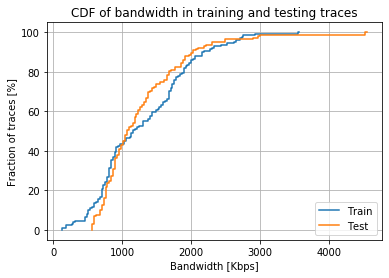

In [16]:
speeds = list()
for trace in os.listdir('net_traces/train_traces/'):
    lines = open('net_traces/train_traces/' + trace).readlines()
    lines = [map(float, line.strip().split()) for line in lines]
    ts, bw = zip(*lines)
    total_bw = 0
    total_ts = 0
    for i in range(1, len(lines)):
        total_bw += (ts[i] - ts[i-1]) * bw[i]
        total_ts = max(total_ts, ts[i])
    speeds.append(1000 * total_bw / total_ts)
    
h, edges = np.histogram(speeds, density=True, bins=len(speeds))
h = np.append([0], np.cumsum(h)/np.cumsum(h).max())
plt.step(edges, 100 * h, label = 'Train')

speeds = list()
for trace in os.listdir('net_traces/traces/'):
    lines = open('net_traces/traces/' + trace).readlines()
    lines = [map(float, line.strip().split()) for line in lines]
    ts, bw = zip(*lines)
    total_bw = 0
    total_ts = 0
    for i in range(1, len(lines)):
        total_bw += (ts[i] - ts[i-1]) * bw[i]
        total_ts = max(total_ts, ts[i])
    speeds.append(1000 * total_bw / total_ts)
    
h, edges = np.histogram(speeds, density=True, bins=len(speeds))
h = np.append([0], np.cumsum(h)/np.cumsum(h).max())
plt.step(edges, 100 * h, label = 'Test')

plt.xlabel('Bandwidth [Kbps]')
plt.ylabel('Fraction of traces [%]')
if not SAVEFIG: plt.title('CDF of bandwidth in training and testing traces')
plt.legend(loc='lower right')

#plt.xticks(np.arange(0, 4700, 100))
#plt.yticks(np.arange(0, 1, 0.05))
plt.grid()

if SAVEFIG: plt.savefig(savedir + 'input_train_test_comparison.pdf', transparent=True, bbox_inches="tight")

# Decision section

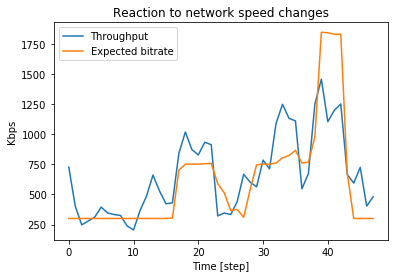

prediction/normal_agent_traces/norway_tram_45.csv


In [17]:
exp = pickle.load(open('explanations/norway_tram_45.explanation.pckl', 'rb'))
time = list(range(exp.length))

values = 8000 * exp.values_over_time('throughput_7')
plt.plot(time, values, label = 'Throughput')

expected = np.zeros(exp.length)
for class_, probs in zip(exp.classes, exp.probs_over_time()):
    expected += int(class_.strip('kbps')) * probs
plt.plot(time, expected, label = 'Expected bitrate')

plt.xlabel('Time [step]')
plt.ylabel('Kbps')
if not SAVEFIG: plt.title('Reaction to network speed changes')
plt.legend()

if SAVEFIG: plt.savefig(savedir + 'decision_reaction.pdf', transparent=True, bbox_inches="tight")
plt.show()
print(exp.trace)

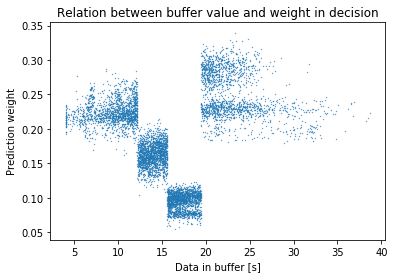

In [18]:
weights = list()
values = list()

for trace in [t for t in os.listdir('explanations/') if t.startswith('norway')]:
    exp = pickle.load(open('explanations/' + trace, 'rb'))
    weights.extend(exp.weights_over_time('buffer_7')[1:])
    values.extend(10 * exp.values_over_time('buffer_7')[1:])
    
plt.scatter(values, weights, s = 0.1)
plt.xlabel('Data in buffer [s]')
plt.ylabel('Prediction weight')
if not SAVEFIG: plt.title('Relation between buffer value and weight in decision')

if SAVEFIG: plt.savefig(savedir + 'decision_buffer_vw.pdf', transparent=True, bbox_inches="tight")

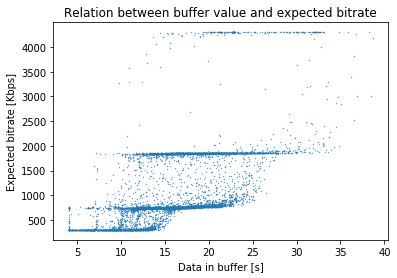

In [19]:
bitrates = list()
values = list()

for trace in os.listdir('explanations/'):
    exp = pickle.load(open('explanations/' + trace, 'rb'))
    
    expected = np.zeros(exp.length)
    for class_, probs in zip(exp.classes, exp.probs_over_time()):
        expected += int(class_.strip('kbps')) * probs
    
    for i in range(48):
        values.append(10 * exp.values_over_time('buffer_7')[i])
        bitrates.append(expected[i])
    
plt.scatter(values, bitrates, s = 0.1)
plt.xlabel('Data in buffer [s]')
plt.ylabel('Expected bitrate [Kbps]')
if not SAVEFIG: plt.title('Relation between buffer value and expected bitrate')

if SAVEFIG: plt.savefig(savedir + 'decision_buffer_vp.pdf', transparent=True, bbox_inches="tight")

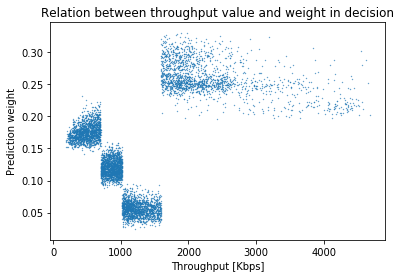

In [20]:
weights = list()
values = list()

for trace in [t for t in os.listdir('explanations/') if t.startswith('norway')]:
    exp = pickle.load(open('explanations/' + trace, 'rb'))
    weights.extend(exp.weights_over_time('throughput_7')[1:])
    values.extend(8000 * exp.values_over_time('throughput_7')[1:])
    
plt.scatter(values, weights, s = 0.1)
plt.xlabel('Throughput [Kbps]')
plt.ylabel('Prediction weight')
if not SAVEFIG: plt.title('Relation between throughput value and weight in decision')

if SAVEFIG: plt.savefig(savedir + 'decision_throughput_vw.pdf', transparent=True, bbox_inches="tight")

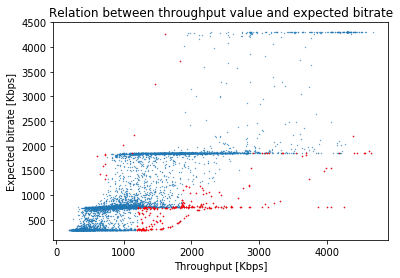

In [21]:
bitrates = list()
values = list()
outliers = list()

for trace in os.listdir('explanations/'):
    exp = pickle.load(open('explanations/' + trace, 'rb'))
    
    expected = np.zeros(exp.length)
    for class_, probs in zip(exp.classes, exp.probs_over_time()):
        expected += int(class_.strip('kbps')) * probs
    
    for i in range(48):
        tp = 8000 * exp.values_over_time('throughput_7')[i]
        br = expected[i]
        
        values.append(tp)
        bitrates.append(br)
        
        if (tp > 750 and br < 300) or (br > 750 and tp < 300)\
           or (tp > 1200 and br < 750) or (br > 1200 and tp < 750)\
           or (tp > 1850 and br < 1200) or (br > 1850 and tp < 1200)\
           or (tp > 2850 and br < 1850) or (br > 2850 and tp < 1850)\
           or (tp > 4300 and br < 2850) or (br > 4300 and tp < 2850):
            outliers.append((tp, br))
    
plt.scatter(values, bitrates, s = 0.1)
plt.scatter(*zip(*outliers), s = 0.3, c='r')
plt.xlabel('Throughput [Kbps]')
plt.ylabel('Expected bitrate [Kbps]')
if not SAVEFIG: plt.title('Relation between throughput value and expected bitrate')

if SAVEFIG: plt.savefig(savedir + 'decision_throughput_vp.pdf', transparent=True, bbox_inches="tight")

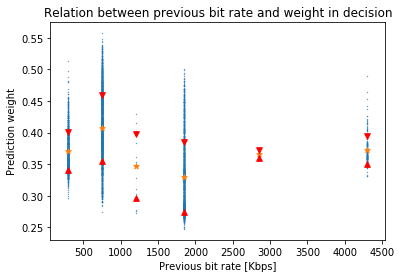

In [22]:
weights = list()
values = list()
BITRATES = [300, 750, 1200, 1850, 2850, 4300]
weights_by_bitrate = {br: list() for br in BITRATES}

for trace in os.listdir('explanations/'):
    exp = pickle.load(open('explanations/' + trace, 'rb'))
    weights.extend(exp.weights_over_time('last_quality_7')[1:])
    values.extend(4300 * exp.values_over_time('last_quality_7')[1:])
    
    for i in range(48):
        weights_by_bitrate[int(4300 * exp.values_over_time('last_quality_7')[i])].append(exp.weights_over_time('last_quality_7')[i])
    
plt.scatter(values, weights, s = 0.1)

plt.scatter(BITRATES, [np.mean(weights_by_bitrate[br]) for br in BITRATES], s = 32, marker='*')
plt.scatter(BITRATES, [np.mean(weights_by_bitrate[br]) - np.std(weights_by_bitrate[br]) for br in BITRATES], s=32, c='r', marker='^')
plt.scatter(BITRATES, [np.mean(weights_by_bitrate[br]) + np.std(weights_by_bitrate[br]) for br in BITRATES], s=32, c='r', marker='v')
            
plt.xlabel('Previous bit rate [Kbps]')
plt.ylabel('Prediction weight')
if not SAVEFIG: plt.title('Relation between previous bit rate and weight in decision')

if SAVEFIG: plt.savefig(savedir + 'decision_bitrate_vw.pdf', transparent=True, bbox_inches="tight")

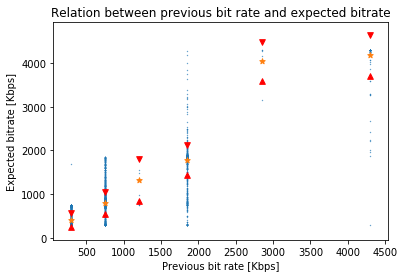

In [23]:
bitrates = list()
values = list()
predicted_by_bitrate = {br: list() for br in BITRATES}

for trace in os.listdir('explanations/'):
    exp = pickle.load(open('explanations/' + trace, 'rb'))
    
    expected = np.zeros(exp.length)
    for class_, probs in zip(exp.classes, exp.probs_over_time()):
        expected += int(class_.strip('kbps')) * probs
    
    for i in range(48):
        values.append(4300 * exp.values_over_time('last_quality_7')[i])
        bitrates.append(expected[i])
        
        predicted_by_bitrate[int(4300 * exp.values_over_time('last_quality_7')[i])].append(expected[i])

    
plt.scatter(values, bitrates, s = 0.1)

plt.scatter(BITRATES, [np.mean(predicted_by_bitrate[br]) for br in BITRATES], s = 32, marker='*')
plt.scatter(BITRATES, [np.mean(predicted_by_bitrate[br]) - np.std(predicted_by_bitrate[br]) for br in BITRATES], s=32, c='r', marker='^')
plt.scatter(BITRATES, [np.mean(predicted_by_bitrate[br]) + np.std(predicted_by_bitrate[br]) for br in BITRATES], s=32, c='r', marker='v')

plt.xlabel('Previous bit rate [Kbps]')
plt.ylabel('Expected bitrate [Kbps]')
if not SAVEFIG: plt.title('Relation between previous bit rate and expected bitrate')

if SAVEFIG: plt.savefig(savedir + 'decision_bitrate_vp.pdf', transparent=True, bbox_inches="tight")